In [38]:
import numpy as np

import pandas as pd

import xgboost as xgb

from xgboost import XGBClassifier

from xgboost import plot_importance

from sklearn.metrics import accuracy_score #準確率

#讀data
# SibSp = 手足 siblings / 配偶 spouses
# Parch = 父母 parents / 小孩 children
dtrain=pd.read_csv("C:/Users/user80917/Desktop/train.csv")
dtest=pd.read_csv("C:/Users/user80917/Desktop/test.csv")

dtrain

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [2]:
from xgboost import XGBRegressor

### 使用 XGBRegressor 填補缺失的年齡屬性

def set_missing_ages(df):
    
    # 把已有的數值型features取出来丢進XGBRegressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    
    # 乘客分成已知年齡和未知年齡兩部分
    known_age = age_df[age_df.Age.notnull()]
    unknown_age = age_df[age_df.Age.isnull()]
    
    # y即目標年齡
    y = known_age.iloc[:, 0]

    # X即feature屬性值
    X = known_age.iloc[:, 1:]
    
    # fit到XGBRegressor之中
    xgbr1 = XGBRegressor(objective="reg:squarederror")
    xgbr1.fit(X, y)
    
    # 用得到的模型進行未知年齡结果預測
    predictedAges = xgbr1.predict(unknown_age.iloc[:, 1:])

    # 用得到的預測结果填補原缺失data
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    return df,xgbr1


#familysize
dtrain['Familysize']=dtrain['Parch']+dtrain['SibSp']
dtest['Familysize']=dtest['Parch']+dtest['SibSp']

#child
dtrain["Child"] = dtrain["Age"].apply(lambda x: 1 if x < 15 else 0)
dtest["Child"] = dtest["Age"].apply(lambda x:1 if x < 15 else 0)

#mother

dtrain['Mother']='0'# DataFrame增加一直行
dtrain.loc[(dtrain.Sex==str("female")) & (dtrain.Parch>=1) ,'Mother']=1

dtest['Mother']='0'# DataFrame增加一直行
dtest.loc[(dtest.Sex==str("female")) & (dtest.Parch>=1) ,'Mother']=1


#cabin
def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

#dtrain
dtrain, rfr = set_missing_ages(dtrain)
dtrain = set_Cabin_type(dtrain)

dtest = set_Cabin_type(dtest)
dtrain

C:\Users\user80917\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user80917\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,Child,Mother
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,No,S,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,Yes,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,No,S,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,Yes,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,No,S,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.0000,No,S,0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.0000,Yes,S,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,20.11429,1,2,W./C. 6607,23.4500,No,S,3,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.0000,Yes,C,0,0,0


In [3]:
#dtrain

#Title1=Name切掉逗號
dtrain['Title1'] = dtrain['Name'].str.split(", ", expand=True)[1]
#Name再用空一格的逗號去切名/姓
dtrain['Name'].str.split(", ", expand=True).head(3)
dtrain['Title1'].head(3)
dtrain['Title1'] = dtrain['Title1'].str.split(".", expand=True)[0]
dtrain['Title1'].head(3)
dtrain['Title1'].unique()

#dtest

#Title1=Name切掉逗號
dtest['Title1'] = dtest['Name'].str.split(", ", expand=True)[1]
#Name再用空一格的逗號去切名/姓
dtest['Name'].str.split(", ", expand=True).head(3)
dtest['Title1'].head(3)
dtest['Title1'] = dtest['Title1'].str.split(".", expand=True)[0]
dtest['Title1'].head(3)
dtest['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [4]:
pd.crosstab(dtrain['Title1'],dtrain['Sex']).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [5]:
pd.crosstab(dtrain['Title1'],dtrain['Survived']).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1


In [6]:
pd.crosstab(dtrain['Title1'],dtrain['Sex']).T.style.background_gradient(cmap='summer_r')
dtrain.groupby(['Title1'])['Age'].mean()

dtest.groupby(['Title1'])['Age'].mean()

Title1
Col       50.000000
Dona      39.000000
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Ms              NaN
Rev       35.500000
Name: Age, dtype: float64

In [7]:
dtrain.groupby(['Title1','Pclass'])['Age'].mean()

dtest.groupby(['Title1','Pclass'])['Age'].mean()

Title1  Pclass
Col     1         50.000000
Dona    1         39.000000
Dr      1         53.000000
Master  1          9.500000
        2          5.000000
        3          7.454615
Miss    1         31.428571
        2         17.370000
        3         19.872647
Mr      1         41.200000
        2         31.718182
        3         27.198795
Mrs     1         45.606061
        2         33.000000
        3         29.875000
Ms      3               NaN
Rev     2         35.500000
Name: Age, dtype: float64

In [8]:
dtrain['Title2'] = dtrain['Title1'].replace(['Mlle','Mme','Ms','Dr','Major','Lady',
                                             'the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                                            
         ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])

dtrain['Title2'].unique()

dtest['Title2'] = dtest['Title1'].replace(['Mlle','Mme','Ms','Dr','Major','Lady',
                                             'the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                                            
         ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])

dtest['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [9]:
dtrain.groupby('Title2')['Age'].mean()

dtest.groupby('Title2')['Age'].mean()

Title2
Master     7.406471
Miss      21.774844
Mr        32.340426
Mrs       38.904762
Name: Age, dtype: float64

In [10]:
dtrain.groupby(['Title2'])['Age'].mean()

dtest.groupby('Title2')['Age'].mean()

Title2
Master     7.406471
Miss      21.774844
Mr        32.340426
Mrs       38.904762
Name: Age, dtype: float64

In [11]:
dtrain.groupby(['Title2','Pclass'])['Age'].mean()

dtest.groupby(['Title2','Pclass'])['Age'].mean()

Title2  Pclass
Master  1          9.500000
        2          5.000000
        3          7.454615
Miss    1         31.428571
        2         17.370000
        3         19.872647
Mr      1         41.812500
        2         31.850877
        3         27.198795
Mrs     1         45.411765
        2         33.000000
        3         29.875000
Name: Age, dtype: float64

In [12]:
pd.crosstab(dtrain['Title2'],dtrain['Sex']).T.style.background_gradient(cmap='summer_r') 
#Checking the Initials with the Sex

Title2,Master,Miss,Mr,Mrs
Sex,,,,
female,0,185,1,128
male,40,0,537,0


In [13]:
pd.crosstab(dtrain['Title2'],dtrain['Survived']).T.style.background_gradient(cmap='summer_r') 
#Checking the Initials with the Sex

Title2,Master,Miss,Mr,Mrs
Survived,,,,
0,17,55,451,26
1,23,130,87,102


In [14]:
list(dtrain.groupby(['Title2','Pclass'])['Age'].mean().iteritems())[:3]

list(dtest.groupby(['Title2','Pclass'])['Age'].mean().iteritems())[:3]

[(('Master', 1), 9.5),
 (('Master', 2), 5.0),
 (('Master', 3), 7.454615384615384)]

In [15]:
dtrain.drop(['Title1'],axis=1,inplace=True)

dtest.drop(['Title1'],axis=1,inplace=True)


In [16]:
dtest

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,Child,Mother,Title2
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,No,Q,0,0,0,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,No,S,1,0,0,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,No,Q,0,0,0,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,No,S,0,0,0,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,No,S,2,0,1,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,No,S,0,0,0,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,Yes,C,0,0,0,Mrs
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,No,S,0,0,0,Mr
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,No,S,0,0,0,Mr


In [17]:
#one hot encoding-dtrain
dtrain['Embarked']=dtrain['Embarked'].fillna('S')
d_Sex=pd.get_dummies(dtrain['Sex'],prefix='Sex')
d_Pclass=pd.get_dummies(dtrain['Pclass'],prefix='Pclass')
d_Embarked=pd.get_dummies(dtrain['Embarked'],prefix='Embarked')
d_Cabin=pd.get_dummies(dtrain['Cabin'],prefix='Cabin')
d_Title2=pd.get_dummies(dtrain['Title2'],prefix='Title2')

#把處理後的新增回dtrain,df
dtrain=pd.concat([dtrain,d_Sex,d_Pclass,d_Embarked,d_Cabin,d_Title2],axis=1)
dtrain.drop(['Name','Sex','Pclass','Embarked','Cabin','Ticket','Title2'],axis=1,inplace=True)

#one hot encoding-dtest
dtest['Embarked']=dtest['Embarked'].fillna('S')
d_Sex=pd.get_dummies(dtest['Sex'],prefix='Sex')
d_Pclass=pd.get_dummies(dtest['Pclass'],prefix='Pclass')
d_Embarked=pd.get_dummies(dtest['Embarked'],prefix='Embarked')
d_Cabin=pd.get_dummies(dtest['Cabin'],prefix='Cabin')
d_Title2=pd.get_dummies(dtest["Title2"],prefix='Title2')

#dtest
dtest=pd.concat([dtest,d_Sex,d_Pclass,d_Embarked,d_Cabin,d_Title2],axis=1)
dtest.drop(['Name','Sex','Pclass','Embarked','Cabin','Ticket','Title2'],axis=1,inplace=True)

dtrain


,PassengerId,Survived,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,...,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs
0,1,0,22.00000,1,0,7.2500,1,0,0,0,...,1,0,0,1,1,0,0,0,1,0
1,2,1,38.00000,1,0,71.2833,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,3,1,26.00000,0,0,7.9250,0,0,0,1,...,1,0,0,1,1,0,0,1,0,0
3,4,1,35.00000,1,0,53.1000,1,0,0,1,...,0,0,0,1,0,1,0,0,0,1
4,5,0,35.00000,0,0,8.0500,0,0,0,0,...,1,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.00000,0,0,13.0000,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
887,888,1,19.00000,0,0,30.0000,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
888,889,0,20.11429,1,2,23.4500,3,0,1,1,...,1,0,0,1,1,0,0,1,0,0
889,890,1,26.00000,0,0,30.0000,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [18]:
#對age和fare標準化至(-1,1)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#dtrain
age_p=scaler.fit(dtrain[['Age']].values.reshape(-1,1))
dtrain['Age_sc']=scaler.fit_transform(dtrain[['Age']].values.reshape(-1,1),age_p)

fare_p=scaler.fit(dtrain[['Fare']].values.reshape(-1,1))
dtrain['Fare_sc']=scaler.fit_transform(dtrain[['Fare']].values.reshape(-1,1),fare_p)

dtrain

,PassengerId,Survived,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,...,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Age_sc,Fare_sc
0,1,0,22.00000,1,0,7.2500,1,0,0,0,...,0,1,1,0,0,0,1,0,-0.568134,-0.502445
1,2,1,38.00000,1,0,71.2833,1,0,0,1,...,0,0,0,1,0,0,0,1,0.624693,0.786845
2,3,1,26.00000,0,0,7.9250,0,0,0,1,...,0,1,1,0,0,1,0,0,-0.269927,-0.488854
3,4,1,35.00000,1,0,53.1000,1,0,0,1,...,0,1,0,1,0,0,0,1,0.401038,0.420730
4,5,0,35.00000,0,0,8.0500,0,0,0,0,...,0,1,1,0,0,0,1,0,0.401038,-0.486337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.00000,0,0,13.0000,0,0,0,0,...,0,1,1,0,0,0,1,0,-0.195376,-0.386671
887,888,1,19.00000,0,0,30.0000,0,0,0,1,...,0,1,0,1,0,1,0,0,-0.791789,-0.044381
888,889,0,20.11429,1,2,23.4500,3,0,1,1,...,0,1,1,0,0,1,0,0,-0.708717,-0.176263
889,890,1,26.00000,0,0,30.0000,0,0,0,0,...,0,0,0,1,0,0,1,0,-0.269927,-0.044381


In [19]:
#邏輯迴歸,我把df換成dtrain了
from sklearn import linear_model

#搜尋(regex)並取出(filter)"XXX_"後的...
train_dtrain=dtrain.filter(regex='Survived|Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')

#轉為np格式
train_np=train_dtrain
y=train_np.iloc[:,0]
X=train_np.iloc[:,1:]

#使用L1正則化(LASSO)
lr=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
lr.fit(X,y)
lr


C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=1e-06, verbose=0,
                   warm_start=False)

In [20]:
#模型係數關聯分析，正數正關聯
pd.DataFrame({"columns":list(train_dtrain.columns)[1:],
              "coef":list(lr.coef_.T)})

,columns,coef
0,SibSp,[-0.12198522868441859]
1,Familysize,[-0.3993668526542803]
2,Mother,[0.19379531784872533]
3,Sex_female,[1.7559238774590844]
4,Pclass_1,[0.5473104694111739]
5,Pclass_3,[-0.997484285083522]
6,Embarked_C,[0.10697241276801385]
7,Embarked_S,[-0.2801123399419092]
8,Cabin_Yes,[0.7623984294626972]
9,Title2_Master,[2.1739949663273137]


In [21]:
from sklearn.model_selection import cross_val_score,train_test_split

#看看評分
clf1=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
all_data=train_dtrain.filter(regex='Survived|Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')
y=all_data.iloc[:,0]
X=all_data.iloc[:,1:]

print(cross_val_score(lr,X,y,cv=5))

#分割data,Training data:CV data=7:3
split_train,split_cv=train_test_split(dtrain,test_size=0.3,random_state=42)

train_df=split_train.filter(regex='Survived|Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')


#生成model
lr=linear_model.LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
lr.fit(train_df.iloc[:,1:],train_df.iloc[:,0])

#對 cross validation data 進行預測
cv_df=split_cv.filter(regex='Survived|Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')
predictions=lr.predict(cv_df.as_matrix()[:,1:])



C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user80917\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

[0.84357542 0.81005587 0.79775281 0.81460674 0.87570621]


In [22]:
dtest

,PassengerId,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,Sex_male,...,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs
0,892,34.5,0,0,7.8292,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,893,47.0,1,0,7.0000,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
2,894,62.0,0,0,9.6875,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
3,895,27.0,0,0,8.6625,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
4,896,22.0,1,1,12.2875,2,0,1,1,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0,0,8.0500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
414,1306,39.0,0,0,108.9000,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
415,1307,38.5,0,0,7.2500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
416,1308,NaN,0,0,8.0500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0


In [23]:
dtrain['Mother']=dtrain['Mother'].astype(str).astype(int)
dtest['Mother']=dtest['Mother'].astype(str).astype(int)
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Familysize       891 non-null int64
Child            891 non-null int64
Mother           891 non-null int32
Sex_female       891 non-null uint8
Sex_male         891 non-null uint8
Pclass_1         891 non-null uint8
Pclass_2         891 non-null uint8
Pclass_3         891 non-null uint8
Embarked_C       891 non-null uint8
Embarked_Q       891 non-null uint8
Embarked_S       891 non-null uint8
Cabin_No         891 non-null uint8
Cabin_Yes        891 non-null uint8
Title2_Master    891 non-null uint8
Title2_Miss      891 non-null uint8
Title2_Mr        891 non-null uint8
Title2_Mrs       891 non-null uint8
Age_sc           891 non-null float64
Fare_sc          891 non-

In [24]:
from xgboost import XGBRegressor

#對Age fit

df_Age=dtest.filter(regex='Age|Parch|SibSp|Mother|Child|Familysize|Title2_.*|Fare_.*|Cabin_.*|Embarked_.*|Pclass_.*')

known_age1=df_Age[dtest.Age.notnull()]
unknown_age1=df_Age[dtest.Age.isnull()]


y2=known_age1.iloc[:,0]
x2=known_age1.iloc[:,1:]

# fit到RandomForestRegressor之中
xgbr=XGBRegressor(objective='reg:squarederror')
xgbr.fit(x2,y2)

# 用得到的模型進行未知年齡结果預測
predAges=xgbr.predict(unknown_age1.iloc[:,1:])

# 用得到的預測结果填補原缺失data
dtest.loc[(dtest.Age.isnull()),'Age']=predAges

dtest


C:\Users\user80917\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user80917\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,PassengerId,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,Sex_male,...,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs
0,892,34.500000,0,0,7.8292,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,893,47.000000,1,0,7.0000,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
2,894,62.000000,0,0,9.6875,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
3,895,27.000000,0,0,8.6625,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
4,896,22.000000,1,1,12.2875,2,0,1,1,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,27.038820,0,0,8.0500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
414,1306,39.000000,0,0,108.9000,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
415,1307,38.500000,0,0,7.2500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
416,1308,27.038820,0,0,8.0500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0


In [25]:
dtest["Fare"]=dtest["Fare"].fillna(value=dtest["Fare"].mean())

dtest

,PassengerId,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,Sex_male,...,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs
0,892,34.500000,0,0,7.8292,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,893,47.000000,1,0,7.0000,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
2,894,62.000000,0,0,9.6875,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
3,895,27.000000,0,0,8.6625,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
4,896,22.000000,1,1,12.2875,2,0,1,1,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,27.038820,0,0,8.0500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
414,1306,39.000000,0,0,108.9000,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
415,1307,38.500000,0,0,7.2500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
416,1308,27.038820,0,0,8.0500,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0


In [26]:
#dtest,用dtrain的mean/std標準化
age_p=scaler.fit(dtrain[['Age']].values.reshape(-1,1))
dtest['Age_sc']=scaler.fit_transform(dtest[['Age']].values.reshape(-1,1),age_p)

fare_p=scaler.fit(dtrain[['Fare']].values.reshape(-1,1))
dtest['Fare_sc']=scaler.fit_transform(dtest[['Fare']].values.reshape(-1,1),age_p)
dtest

,PassengerId,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,Sex_male,...,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Age_sc,Fare_sc
0,892,34.500000,0,0,7.8292,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0.344329,-0.498162
1,893,47.000000,1,0,7.0000,1,0,0,1,0,...,0,1,1,0,0,0,0,1,1.314068,-0.513029
2,894,62.000000,0,0,9.6875,0,0,0,0,1,...,1,0,1,0,0,0,1,0,2.477755,-0.464844
3,895,27.000000,0,0,8.6625,0,0,0,0,1,...,0,1,1,0,0,0,1,0,-0.237514,-0.483222
4,896,22.000000,1,1,12.2875,2,0,1,1,0,...,0,1,1,0,0,0,0,1,-0.625410,-0.418228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,27.038820,0,0,8.0500,0,0,0,0,1,...,0,1,1,0,0,0,1,0,-0.234503,-0.494204
414,1306,39.000000,0,0,108.9000,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0.693435,1.313976
415,1307,38.500000,0,0,7.2500,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0.654646,-0.508547
416,1308,27.038820,0,0,8.0500,0,0,0,0,1,...,0,1,1,0,0,0,1,0,-0.234503,-0.494204


In [35]:
#用classifier模型預測-0.76準確率
from xgboost import XGBClassifier

train_df=dtrain.filter(regex='Survived|Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')

#y即Survival結果
y=train_df.iloc[:,0]

#X即features屬性值
X=train_df.iloc[:,1:]

xgbc=XGBClassifier(n_estimators=200,
                   colsample_bytree= 0.9,
                   eta =0.1,
                   max_delta_step= 0,
                   max_depth= 5,
                   min_child_weight= 2,
                   reg_alpha=0,
                   reg_lambda= 0.2,
                   scale_pos_weight= 0.6,
                   subsample=0.5)

xgbc.fit(X,y)


df_test=dtest.filter(regex='Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')

predictions=xgbc.predict(df_test)



result = pd.DataFrame({'PassengerId':dtest['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})

result.to_csv("C:/Users/user80917/Desktop/XGBCpredict.csv",index=False)



C:\Users\user80917\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [28]:

"""
from sklearn.model_selection import GridSearchCV
from time import time

start=time()

#1387秒/4374種 平均1s跑3種組合...
parameters = {
              'max_depth': [5, 10],
              'learning_rate': [0.01, 0.02, 0.1],
              'min_child_weight': [0, 2,10],
              'max_delta_step': [0, 0.2, 0.6],
              'colsample_bytree': [0.5, 0.7,0.9],
              'reg_alpha': [0, 0.25, 0.5],
              'reg_lambda': [0.2, 0.6, 1],
              'scale_pos_weight': [0.2,0.6, 1]

}

gsearch = GridSearchCV(xgbc, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(X,y)

print("gridsearchcv 花了 %.2f 秒 "% (time()-start))
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
>>>
gridsearchcv 花了 1386.68 秒 
Best score: 0.845
Best parameters set:
	colsample_bytree: 0.9
	learning_rate: 0.1
	max_delta_step: 0
	max_depth: 5
	min_child_weight: 2
	reg_alpha: 0
	reg_lambda: 0.2
	scale_pos_weight: 0.6

"""


gridsearchcv 花了 1386.68 秒 
Best score: 0.845
Best parameters set:
	colsample_bytree: 0.9
	learning_rate: 0.1
	max_delta_step: 0
	max_depth: 5
	min_child_weight: 2
	reg_alpha: 0
	reg_lambda: 0.2
	scale_pos_weight: 0.6


In [29]:
dtrain['Mother']=dtrain['Mother'].astype(int)
dtest['Mother']=dtest['Mother'].astype(int)

In [30]:
dtest

,PassengerId,Age,SibSp,Parch,Fare,Familysize,Child,Mother,Sex_female,Sex_male,...,Embarked_Q,Embarked_S,Cabin_No,Cabin_Yes,Title2_Master,Title2_Miss,Title2_Mr,Title2_Mrs,Age_sc,Fare_sc
0,892,34.500000,0,0,7.8292,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0.344329,-0.498162
1,893,47.000000,1,0,7.0000,1,0,0,1,0,...,0,1,1,0,0,0,0,1,1.314068,-0.513029
2,894,62.000000,0,0,9.6875,0,0,0,0,1,...,1,0,1,0,0,0,1,0,2.477755,-0.464844
3,895,27.000000,0,0,8.6625,0,0,0,0,1,...,0,1,1,0,0,0,1,0,-0.237514,-0.483222
4,896,22.000000,1,1,12.2875,2,0,1,1,0,...,0,1,1,0,0,0,0,1,-0.625410,-0.418228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,27.038820,0,0,8.0500,0,0,0,0,1,...,0,1,1,0,0,0,1,0,-0.234503,-0.494204
414,1306,39.000000,0,0,108.9000,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0.693435,1.313976
415,1307,38.500000,0,0,7.2500,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0.654646,-0.508547
416,1308,27.038820,0,0,8.0500,0,0,0,0,1,...,0,1,1,0,0,0,1,0,-0.234503,-0.494204


In [31]:
#用原生api做做看(train)
train_df=dtrain.filter(regex='Survived|Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')

df_test=dtest.filter(regex='Age_sc|SibSp|Mother|Familysize|Title2_Mr|Title2_Mrs|Title2_Master|Fare_sc|Cabin_Yes|Embarked_C|Embarked_S|Sex_female|Pclass_1|Pclass_3')

#y即Survival結果,只有label要轉array
y = train_df['Survived'].values

#X即features屬性值
X = train_df.iloc[:, 1:]

#X_test為test集的features部分
X_test = df_test.iloc[:]

from sklearn.ensemble import BaggingClassifier

Xtrain = xgb.DMatrix(X, label=y)
Xtest = xgb.DMatrix(X_test)

param = {'max_depth':5, 
        'eta':0.02, 
        'silent':0, 
        'objective':'binary:logistic',
        'eval_metric': "error",
        'subsample': 0.5,
        'colsample_bytree': 0.7,
        'booster': "gbtree"
             }

num_round=200

evallist  = [(Xtrain, 'train')]

xgbmodel = xgb.train( param, Xtrain, num_round, evallist)
    
prediction=xgbmodel.predict(Xtest)

submission = pd.DataFrame({"PassengerId":dtest['PassengerId'].values, "Survived":prediction})

#四捨五入
submission['Survived']=submission['Survived'].apply(lambda x:1 if x>=0.5 else 0)

submission.to_csv("C:/Users/user80917/Desktop/submission200.csv", index=False)








[0]	train-error:0.169473
[1]	train-error:0.164983
[2]	train-error:0.154882
[3]	train-error:0.156004
[4]	train-error:0.156004
[5]	train-error:0.156004
[6]	train-error:0.151515
[7]	train-error:0.150393
[8]	train-error:0.151515
[9]	train-error:0.147026
[10]	train-error:0.144781
[11]	train-error:0.148148
[12]	train-error:0.148148
[13]	train-error:0.148148
[14]	train-error:0.150393
[15]	train-error:0.151515
[16]	train-error:0.148148
[17]	train-error:0.150393
[18]	train-error:0.144781
[19]	train-error:0.144781
[20]	train-error:0.144781
[21]	train-error:0.143659
[22]	train-error:0.144781
[23]	train-error:0.141414
[24]	train-error:0.141414
[25]	train-error:0.143659
[26]	train-error:0.144781
[27]	train-error:0.148148
[28]	train-error:0.144781
[29]	train-error:0.141414
[30]	train-error:0.144781
[31]	train-error:0.143659
[32]	train-error:0.139169
[33]	train-error:0.140292
[34]	train-error:0.141414
[35]	train-error:0.141414
[36]	train-error:0.140292
[37]	train-error:0.141414
[38]	train-error:0.141

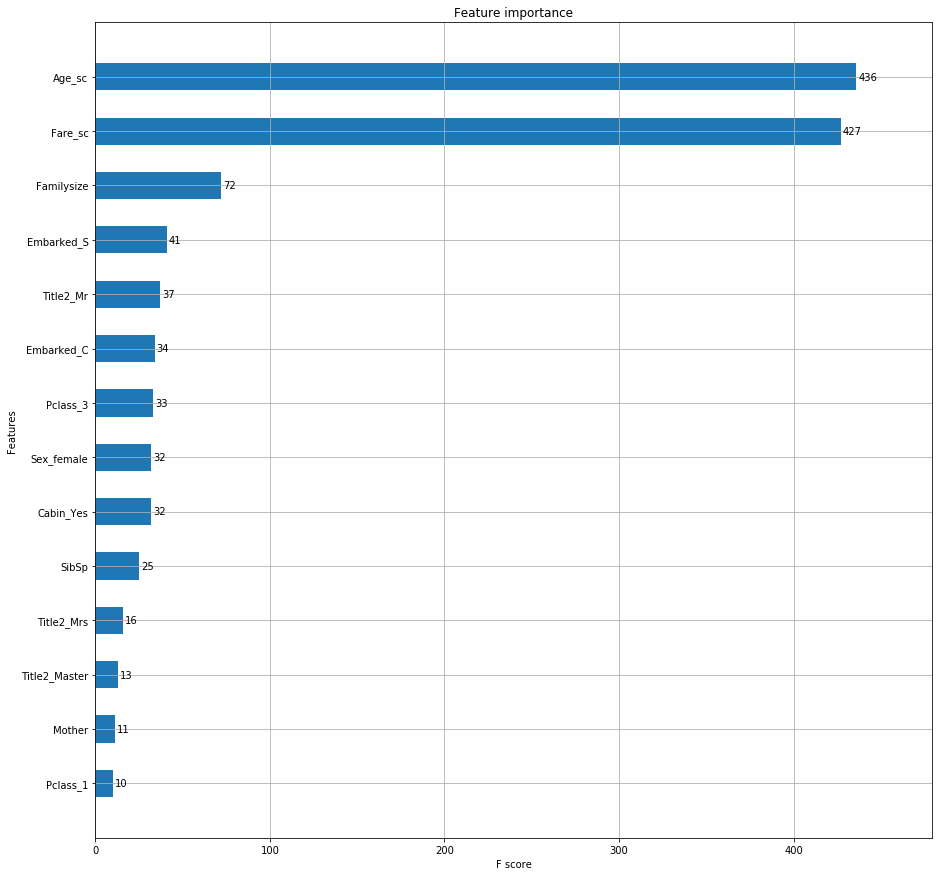

In [32]:
import matplotlib.pyplot as plt
from xgboost import plot_importance


fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgbc,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()